In [1]:
import pandas as pd 

**RecordID** - identifier of the row of data   
**IP Address** - address of the user, who is visiting website   
**LoggedInFlag** - when user has an account and logged in   
**ServerID** - one of the servers user was routed through   
**VisitPageFlag** - when user clicked on the loyalty program page   

Changing (the element being tested) from ___________ to ___________ will increase/decrease ratio of those who enter the target page.   
So the ratio of those who visit the target page should been calculated. 

In [2]:
df = pd.read_csv('data/grocerywebsiteabtestdata.csv')
df.head(15)

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0
5,6,23.5.199.2,1,3,0
6,7,195.12.126.2,1,1,0
7,8,97.6.126.6,0,3,1
8,9,93.10.165.4,1,1,0
9,10,180.3.76.4,1,1,0


In [3]:
df.describe()

,RecordID,LoggedInFlag,ServerID,VisitPageFlag
count,184588.000000,184588.000000,184588.000000,184588.000000
mean,92294.500000,0.503657,1.999691,0.058184
std,53286.110082,0.499988,0.816719,0.234091
min,1.000000,0.000000,1.000000,0.000000
25%,46147.750000,0.000000,1.000000,0.000000
50%,92294.500000,1.000000,2.000000,0.000000
75%,138441.250000,1.000000,3.000000,0.000000
max,184588.000000,1.000000,3.000000,1.000000


Assuming that some users count visited the website several times, these visits were reduced to 1 visit, so this doesn't affect the final result.

In [4]:
df = df.groupby(['IP Address', 'LoggedInFlag', 'ServerID'])['VisitPageFlag'].sum()
df = df.reset_index(name = "VisitPageFlagSum")
df["VisitPageFlag"] = df["VisitPageFlagSum"].apply(lambda x: 1 if x>0 else 0)

<AxesSubplot:xlabel='VisitPageFlag', ylabel='Count'>

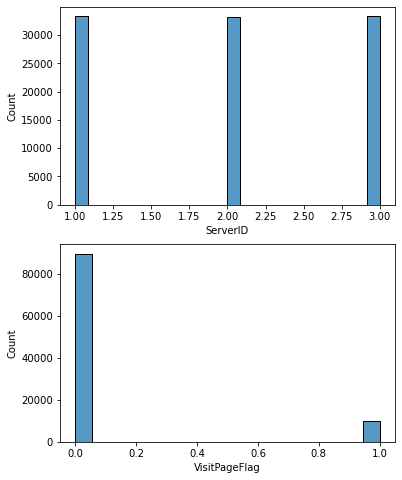

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(6,8))
sns.histplot(data=df['ServerID'], ax=axes[0])
sns.histplot(data=df['VisitPageFlag'], ax=axes[1])

The data is splitted by ServerID (the first one is for the Treatment sample, the rest are for the Control sample)

In [6]:
df['group'] = df['ServerID'].map({1:'Treatment', 2: 'Control', 3: 'Control'})
df = df.drop(['ServerID','VisitPageFlagSum', 'LoggedInFlag'], axis=1)
df.head()

,IP Address,VisitPageFlag,group
0,0.0.108.2,0,Treatment
1,0.0.109.6,0,Treatment
2,0.0.111.8,0,Control
3,0.0.160.9,0,Control
4,0.0.163.1,0,Control


In [7]:
df_control = df[df['group'] == 'Control'].reset_index(drop=True)
df_treatment = df[df['group'] == 'Treatment'].reset_index(drop=True)

### Control

In [8]:
df_control.describe().T

,count,mean,std,min,25%,50%,75%,max
VisitPageFlag,66460.0,0.092251,0.289382,0.0,0.0,0.0,0.0,1.0


In [9]:
# the ratio of those who visit the target page for control sample
control_ratio_visit = df_control[df_control['VisitPageFlag'] == 1].shape[0] / df_control.shape[0]
control_ratio_visit 

0.09225097803189888

### Treatment

In [10]:
df_treatment.describe().T

,count,mean,std,min,25%,50%,75%,max
VisitPageFlag,33303.0,0.115515,0.319647,0.0,0.0,0.0,0.0,1.0


In [11]:
# the ratio of those who visit the target page for treatment sample
treatment_ratio_visit = df_treatment[df_treatment['VisitPageFlag'] == 1].shape[0] / df_treatment.shape[0]
treatment_ratio_visit 

0.11551511875806984

### Normality Assumption

H0 : The assumption of normality is provided.     
H1 : The assumption of normality is not provided.

alpha - 0.05

In [12]:
from scipy.stats import shapiro # Shapiro-Wilk test
from scipy.stats import kstest # Kolmogorov–Smirnov test

In [13]:
test_statistic, p_value = shapiro(df['VisitPageFlag'])
if p_value > 0.05:
    print('The assumption of normality is provided')
else:
    print('The assumption of normality is not provided')

The assumption of normality is not provided


/Users/vittoria/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [14]:
result = kstest(df['VisitPageFlag'], "norm")
if result.pvalue > 0.05:
    print('The assumption of normality is provided')
else:
    print('The assumption of normality is not provided')

The assumption of normality is not provided


### Variance Homogeneity     
H0 : Variances are homogeneous    
H1 : Variances are not homogeneous 

alpha - 0.05

In [15]:
from scipy.stats import levene
# Levene test for equal variances.

In [16]:
test_stat, pvalue = levene(df_control['VisitPageFlag'], df_treatment['VisitPageFlag'])
if p_value > 0.05:
    print('Variances are homogeneous') 
else:
    print('Variances are not homogeneous')

Variances are not homogeneous


### Mann-Whitney U test    
(The U test (non-parametric test) is performed if normality and homogeneity of variance are not provided)

In terms of click rate to the desired page:      
H0 : There is no significant difference between the two groups.    
H1 : There is a difference between the two groups.

alpha - 0.05

In [17]:
from scipy.stats.mstats import mannwhitneyu

In [18]:
statistic, p_value = mannwhitneyu(df_control['VisitPageFlag'], df_treatment['VisitPageFlag'])
if p_value > 0.05:
    print('There is no significant difference between the two groups in terms of click rate to the desired page.') 
else:
    print('There is a difference between the two groups in terms of click rate to the desired page.')


There is a difference between the two groups in terms of click rate to the desired page.


In [19]:
pdd = df.groupby(['group','VisitPageFlag']).count()
pdd 

IP Address
group     VisitPageFlag            
Control   0                   60329
          1                    6131
Treatment 0                   29456
          1                    3847

In [20]:
group_count = df.groupby(['group', 'VisitPageFlag'])['group'].count().reset_index(name='Count')
group_count = pd.crosstab(index=group_count['group'], columns=group_count['VisitPageFlag'], 
            values=group_count['Count'], aggfunc=sum, margins=True)
group_count

VisitPageFlag,0,1,All
group,,,
Control,60329,6131,66460
Treatment,29456,3847,33303
All,89785,9978,99763


In [21]:
groupped = group_count.div(group_count['All'], axis=0)
groupped

VisitPageFlag,0,1,All
group,,,
Control,0.907749,0.092251,1.0
Treatment,0.884485,0.115515,1.0
All,0.899983,0.100017,1.0


In [22]:
group_count.loc['Treatment']['All']

33303

In [23]:
groupped.loc['Treatment'][1] 

0.11551511875806984

#### Confidence Interval

In [24]:
import numpy as np

def confidence_interval(T, N, z=0.95):
    if z == 0.9:
        z = 1.645
    elif z == 0.95:
        z = 1.96
    else:
        z = 2.58
    return (np.round((T - z * ((T*(1-T))/N)), 5), np.round((T + z * ((T*(1-T))/N)), 5))

In [25]:
print('Treatment', confidence_interval(groupped.loc['Treatment'][1], group_count.loc['Treatment']['All']))

Treatment (0.11551, 0.11552)


### Conclusion: 
**The rate increased to 11.55% in the Treatment group, and its increase is not accidental, but has been proven statistically.**